In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload


In [2]:
## Which cacatoes data ? SAM 300K 2D
cacatoes_dir_path = "/homedata/fiolleau/RCE/CACATOES/"
sam_dir_path = "/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/"

In [55]:
n_days = 1 # number of days to extract 

In [56]:
#Open CACATOES data, 
ds1 = xr.open_dataset(cacatoes_dir_path+"cacatoes_rcemip_SAM_RCE_large300_2D.nc")
ds1["time"] = (ds1["time"]/8.64e13).astype(int)
ds1 = ds1.isel(time=slice(n_days)) 
ds1

<xarray.Dataset>
Dimensions:                       (Y: 4, X: 62, time: 1, CondPrecip: 17,
                                   MCS: 150)
Coordinates:
  * time                          (time) int64 0
  * CondPrecip                    (CondPrecip) int16 0 1 2 3 4 ... 25 30 35 40
Dimensions without coordinates: Y, X, MCS
Data variables: (12/41)
    Ygrid                         (Y) float32 ...
    Xgrid                         (X) float32 ...
    DAILYmcs_Pop                  (time, Y, X) float32 ...
    DAILY_OLR                     (time, Y, X) float32 ...
    DAILY_precip                  (time, Y, X) float32 ...
    DAILY_conditionalprecip       (time, CondPrecip, Y, X) float32 ...
    ...                            ...
    INT_gridtimeOccupation_start  (time, MCS, Y, X) float64 ...
    INT_gridtimeOccupation_end    (time, MCS, Y, X) float64 ...
    INT_surfFraction_235K         (time, MCS, Y, X) float32 ...
    INT_surfFraction_220K         (time, MCS, Y, X) float32 ...
    INT_surfFraction_210K         (time, MCS, Y, X) float32 ...
    INT_surfFraction_200K         (time, MCS, Y, X) float32 ...

In [57]:
ds2 = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_300K_64.2Dcom_1.nc")
ds2 = ds2.isel(time=slice(48*n_days)).isel(x=slice(48, -16))
ds2["x"] = ((ds2["x"]-9.6e4)/3e3).astype(int)
ds2["y"] = (ds2["y"]/3e3).astype(int) 
ds2["time"] = np.round(((ds2["time"]-75)*48)).astype(int)         
ds2

<xarray.Dataset>
Dimensions:   (x: 1984, y: 128, time: 48)
Coordinates:
  * x         (x) int64 16 17 18 19 20 21 22 ... 1994 1995 1996 1997 1998 1999
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46 47
Data variables: (12/69)
    Prec      (time, y, x) float32 ...
    SHF       (time, y, x) float32 ...
    LHF       (time, y, x) float32 ...
    LWNS      (time, y, x) float32 ...
    LWNSC     (time, y, x) float32 ...
    LWNT      (time, y, x) float32 ...
    ...        ...
    rsuscs    (time, y, x) float32 ...
    hadvfmse  (time, y, x) float32 ...
    vadvfmse  (time, y, x) float32 ...
    advfmse   (time, y, x) float32 ...
    VIH_inst  (time, y, x) float32 ...
    var_h_in  (time, y, x) float32 ...

In [ ]:
## Data analysis, nothing happens
Surf = ds1["QCcacatoes_SurfGridPoint"].values
Precip1 = ds1["DAILY_precip"].values
Precip2 = ds2["Prec"].values
Precip1.max() #67.23966
Precip2.max() # 5189.414
Precip2.max()/48 #108.11279296875
print(ds2["Prec"].values.mean(axis=(0)).sum()/48, ds1["DAILY_precip"].values.sum())
np.multiply(ds1["QCcacatoes_SurfGridPoint"].values, ds1["DAILY_precip"].values).sum()/ds1["QCcacatoes_SurfGridPoint"].values.sum()

108.11279296875

In [59]:
#Processing bunch of data
ds2_shape = (1984, 128, 48)
ds2_Prec = ds2["Prec"].stack(flat=('x', 'y', 'time')).to_numpy()
dist_SAM_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 6, fill_last_decade=True)
dist_SAM_Prec.computeDistribution(sample = ds2_Prec)
dist_SAM_Prec.storeSamplePoints(sample = ds2_Prec)

ds1_shape = (4, 62)
ds1_Prec = ds1["DAILY_precip"] #Precipitation daily average of the pixels with values equal or larger than 0 mm/h for each 1deg. x 1deg. grid points in one day
ds1_CondPrec= ds1["DAILY_conditionalprecip"][0,:,:]
ds1_FracPrec= ds1["DAILYprecipfrac"][0,:,:]

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [60]:
## Prepare data

SAM_ranks = dist_SAM_Prec.ranks[:]
SAM_bin_locations = dist_SAM_Prec.bin_locations[:]
ranks=[]
loc = []
for r, bin_loc in zip(SAM_ranks, SAM_bin_locations) : 
    index_3d_x, index_3d_y = np.unravel_index(bin_loc, ds2_shape)[0], np.unravel_index(bin_loc, ds2_shape)[1]
    for x,y in zip(index_3d_x, index_3d_y):
        ranks.append(r)
        loc.append((x,y))


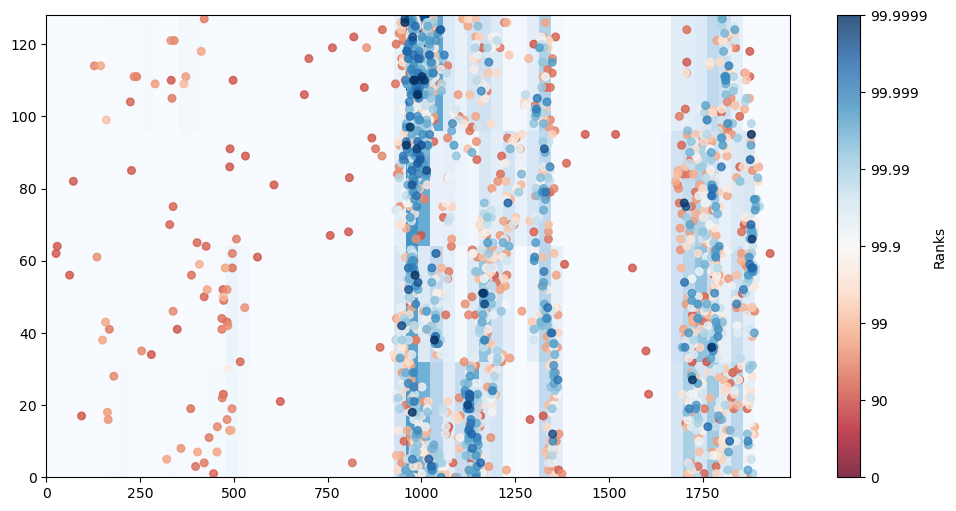

In [61]:
%matplotlib inline
from myFuncs import Normalize_IL as norm

norm = colors.FuncNorm((norm(nd=6)._transform_IL, norm(nd=6)._inverse_IL), vmin = 0)
ticks = [0, 90, 99, 99.9, 99.99, 99.999, 99.9999]
ticklabels = ['{:.4f}'.format(t).rstrip('0').rstrip('.') for t in ticks]

fig, ax = plt.subplots(figsize=(12,6))
sc = ax.scatter([c[0] for c in loc], [c[1] for c in loc], c=ranks, cmap="RdBu", norm=norm, s=30, alpha=0.8)
ax.imshow(ds1_Prec[0,:,:], extent=[0, 62*32, 0, 4*32], aspect='auto', cmap='Blues', origin = 'lower')
cbar = fig.colorbar(sc)
cbar.set_label('Ranks')
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)
plt.savefig("../figures/SAM_extremes_plotted_over_CACATOES_Daily_Precip.png", dpi= 600)
plt.show()

In [40]:
## Now we coarsen ds2 data trough mean, max and sum to compare to ds1
window = {'time': 48, 'x' : 32, 'y' : 32} ## ça marche pas car il faut sommer sur les pas de temps et moyenner sur l'espace
ds2_Prec_mean = ds2["Prec"].coarsen(window).mean().to_numpy()
ds2_Prec_sum = ds2["Prec"].coarsen(window).sum().to_numpy()
ds2_Prec_max = ds2["Prec"].coarsen(window).max().to_numpy()

In [41]:
#Analysis the aggregated data
ds2_Prec_mean[0,0,2] #(T : 1, Y: 4, X : 62)
ds2["Prec"][0:48,0:32,2*32:3*32].values.mean() #4.36652964e-03
ds1["DAILY_precip"].values.mean() #4.71814
ds2["Prec"].values.mean() #4.894335

4.894334

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


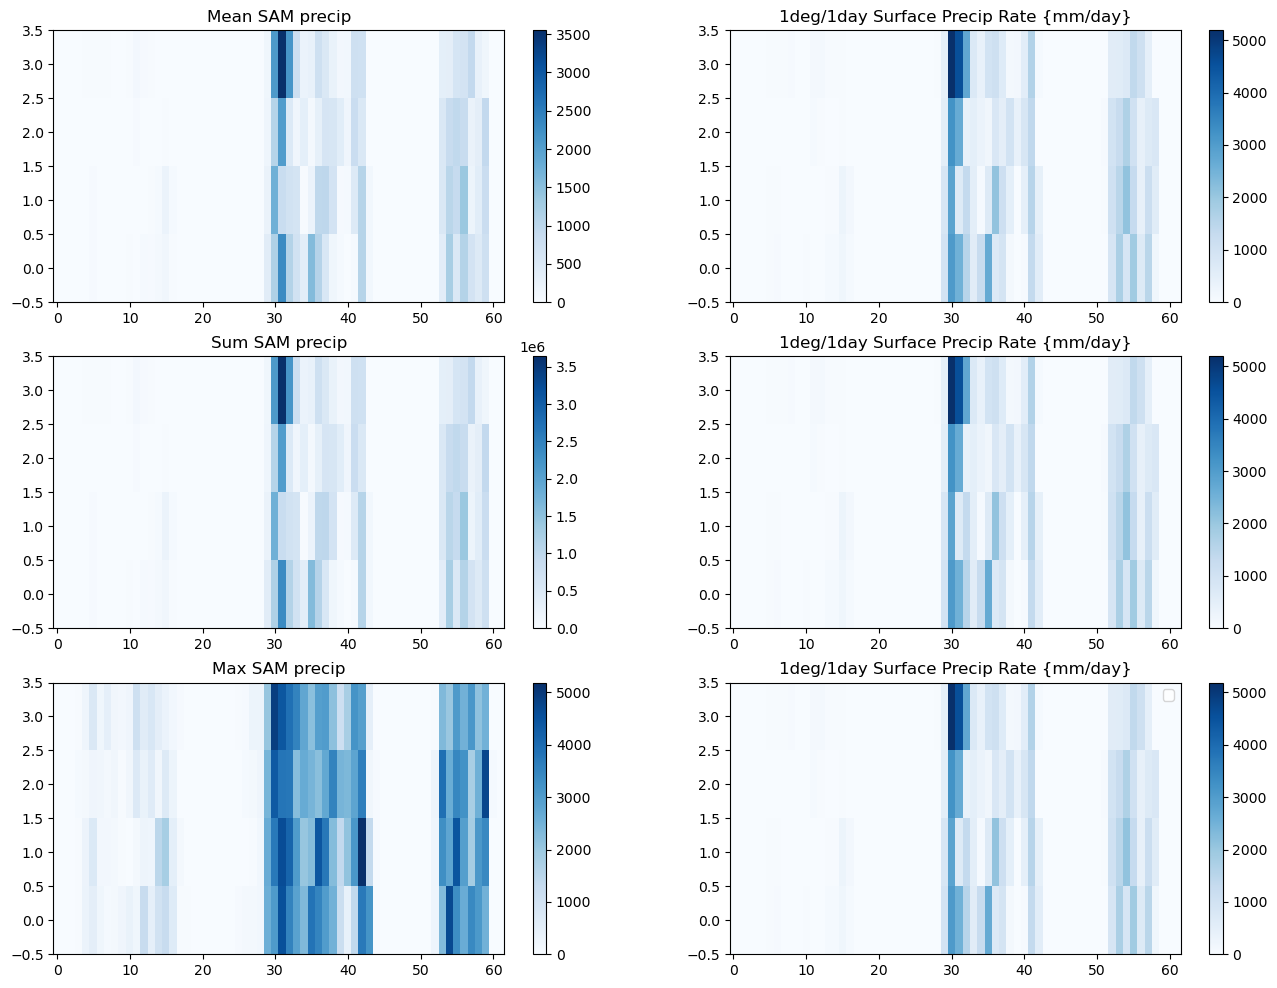

In [42]:
## plotting 

fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (16, 12))

img = axs[0, 0].imshow(ds2_Prec_mean[0,:,:]*48, aspect='auto', cmap='Blues', origin = 'lower', label = "mean")
axs[0, 0].set_title("Mean SAM precip")
fig.colorbar(img, ax = axs[0,0])


img =axs[1, 0].imshow(ds2_Prec_sum[0,:,:], aspect='auto', cmap='Blues', origin = 'lower', label = "sum")
axs[1, 0].set_title("Sum SAM precip")
fig.colorbar(img, ax = axs[1,0])


img = axs[2, 0].imshow(ds2_Prec_max[0,:,:], aspect='auto', cmap='Blues', origin = 'lower', label = "max")
axs[2, 0].set_title("Max SAM precip")
fig.colorbar(img, ax = axs[2,0])


for i in range(3):
    axs[i, 1].imshow(ds1_Prec[0,:,:], aspect='auto', cmap='Blues', origin = 'lower')
    axs[i, 1].set_title("1deg/1day Surface Precip Rate {mm/day}")
    fig.colorbar(img, ax = axs[i,1])


plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


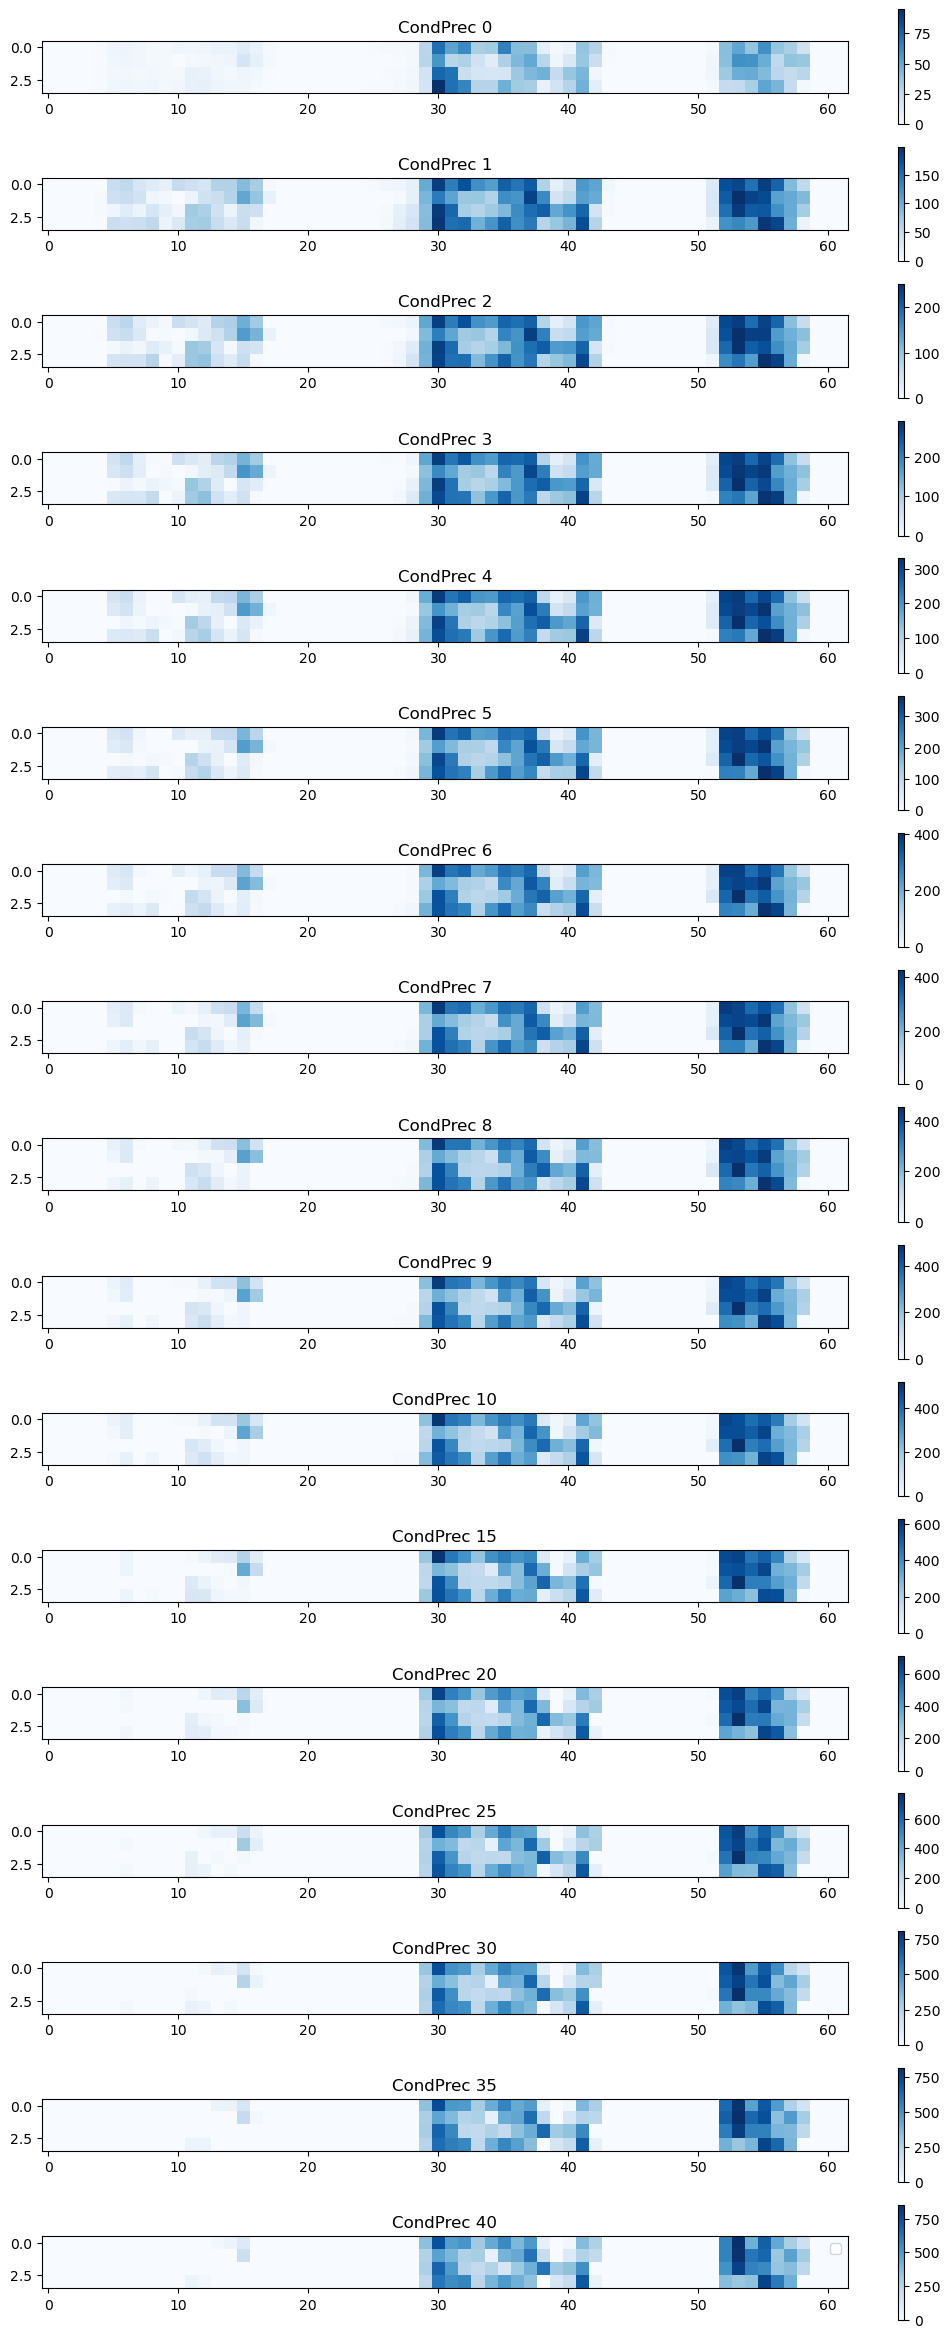

In [12]:
d0 = ds1_CondPrec.shape[0] 
fig, axs = plt.subplots(17, 1, figsize=(2^16-1, 30))

for data, ax, i in zip(ds1_CondPrec, axs.flatten(), [i for i in range(17)]):
    img = ax.imshow(data, cmap = 'Blues')
    ax.set_title(f'CondPrec {ds1["CondPrecip"][i].values}')
    fig.colorbar(img, ax=ax)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


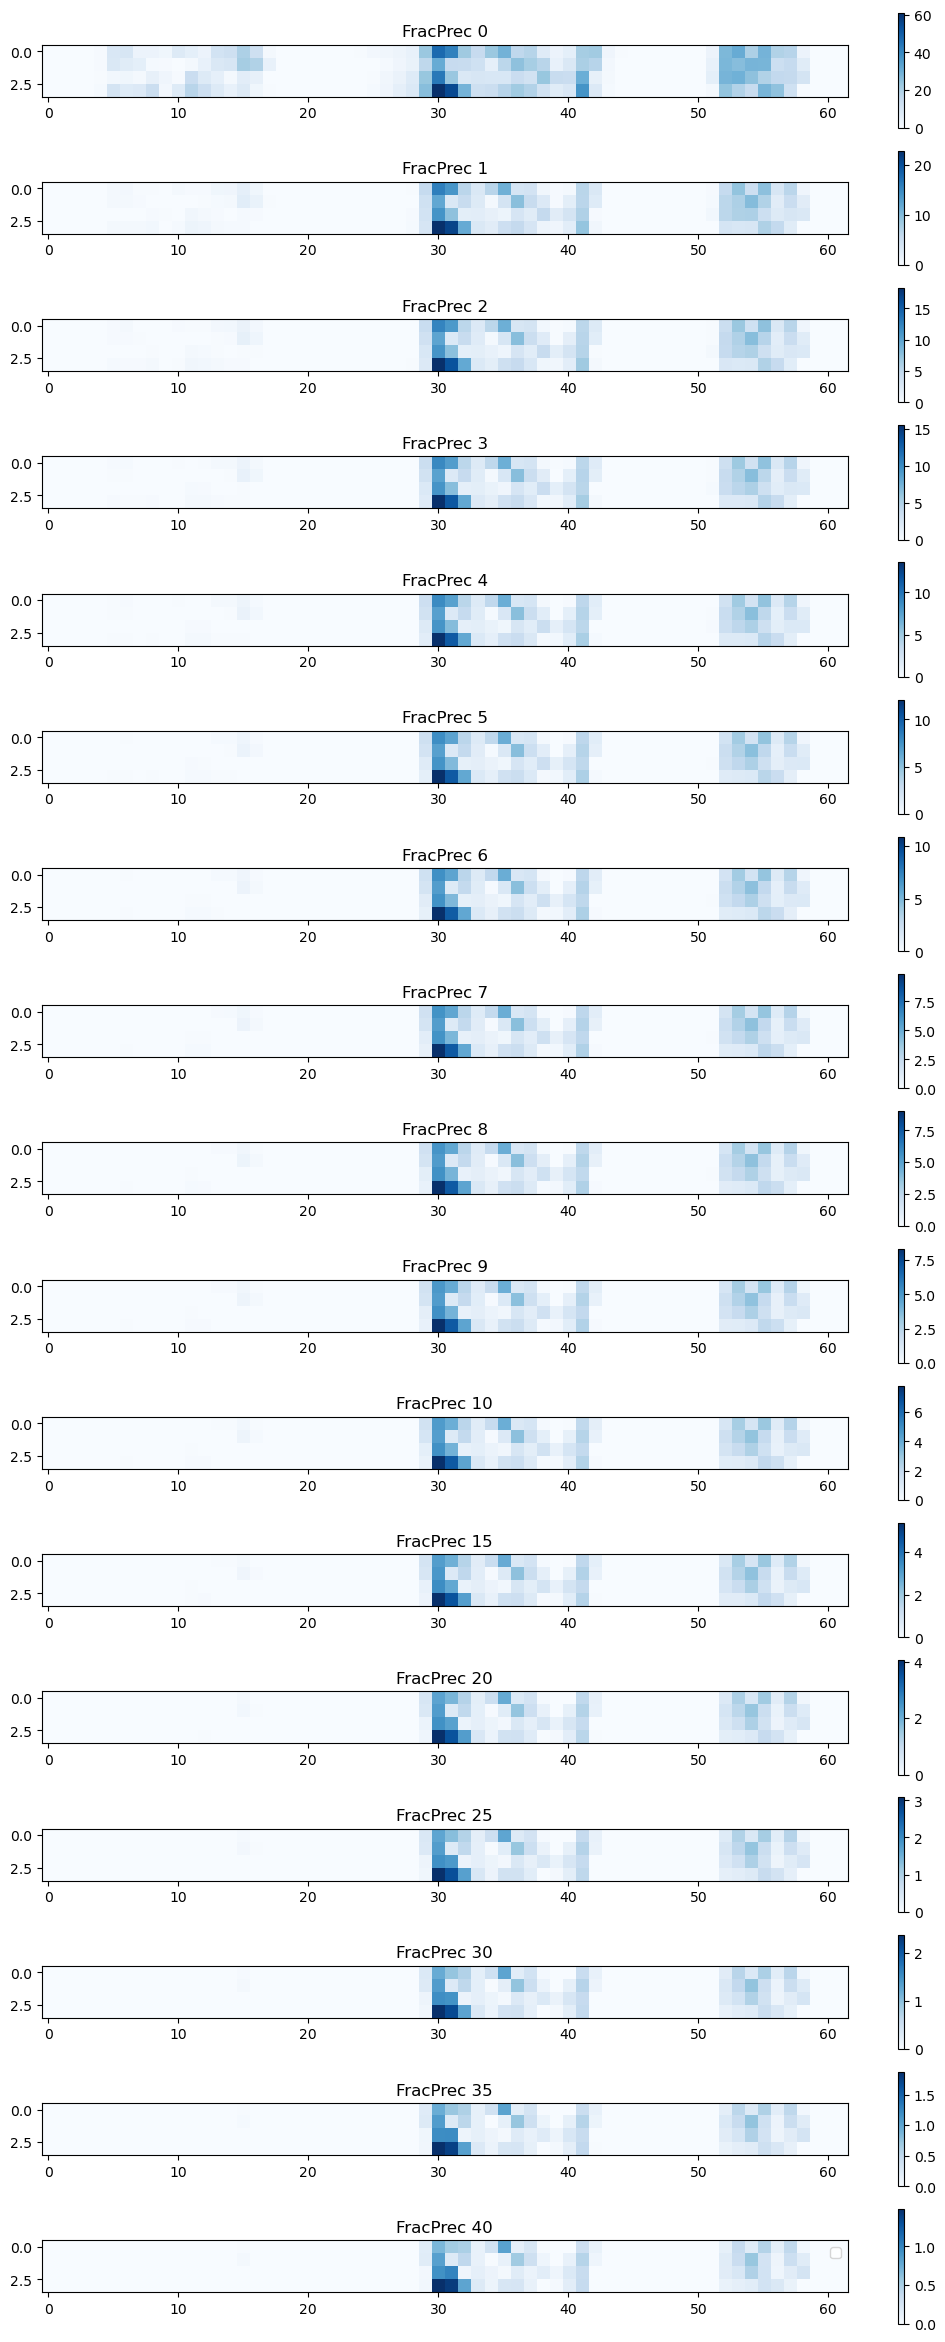

In [13]:
d0 = ds1_FracPrec.shape[0] 
fig, axs = plt.subplots(17, 1, figsize=(2^16-1, 30))

for data, ax, i in zip(ds1_FracPrec, axs.flatten(), [i for i in range(17)]):
    img = ax.imshow(data, cmap = 'Blues')
    ax.set_title(f'FracPrec {ds1["CondPrecip"][i].values}')
    fig.colorbar(img, ax=ax)
    
plt.legend()
plt.show()
